# Sensitivity tests

In [66]:
import math
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt

fn_ant = '../model/PBK_PFAS.ant'

def loadParametrisation(model, filename):
    df = pd.read_csv(filename)
    df['Value'] = df['Value'].astype(float)
    for index, row in df.iterrows():
        model[str(row['Parameter'])] = row['Value']

# Simulate daily oral dosing

Simulate model with daily oral dosing provided as a repetitively triggered event.

In [67]:
def simulate(
    daily_per_bw_intake = 0.1,
    days_of_exposure = 30 * 365,
    days_after_exposure = 10 * 365,
    bw = 70
):
    """
    Runs model simulation with the specified intake.

    :param daily_per_bw_intake: daily (per bw) intake (in ug/kg bw/day)
    :param days_of_exposure: number days of simulated exposure
    :param days_after_exposure: number simulated days after exposure has ended
    :param bw: bodyweight (in kg)
    :return: describe what it returns
    """

    # Load the PBPK model from the SBML file
    rr_model = te.loada(fn_ant)

    # Specify the input
    input_id = 'AG'

    # Make sure A_gut is not constant and does not have boundary conditions
    rr_model.setInitAmount(input_id, 0)
    rr_model.setConstant(input_id, False)
    rr_model.setBoundary(input_id, False)

    # Remove all events
    for event_id in rr_model.model.getEventIds():
        rr_model.removeEvent(event_id)

    num_days = days_of_exposure + days_after_exposure

    # Set chemical parameters
    loadParametrisation(rr_model, '../Parametrisations/PFOA_Human.csv')

    # Set physiological parameters
    rr_model.BW = bw

    # Create a repeating daily oral dosing
    eid = f"oral_daily_exposure"
    rr_model.addEvent(eid, False, f"time % 1 == 0 && time < {days_of_exposure}", False)
    rr_model.addEventAssignment(eid, input_id, f"{input_id} + {daily_per_bw_intake}", False)
    rr_model.regenerateModel(True, True)

    # Simulate the PBPK model
    results = rr_model.simulate(0, num_days, 24 * num_days + 1)
    return (results, rr_model.timeCourseSelections)


## Report results

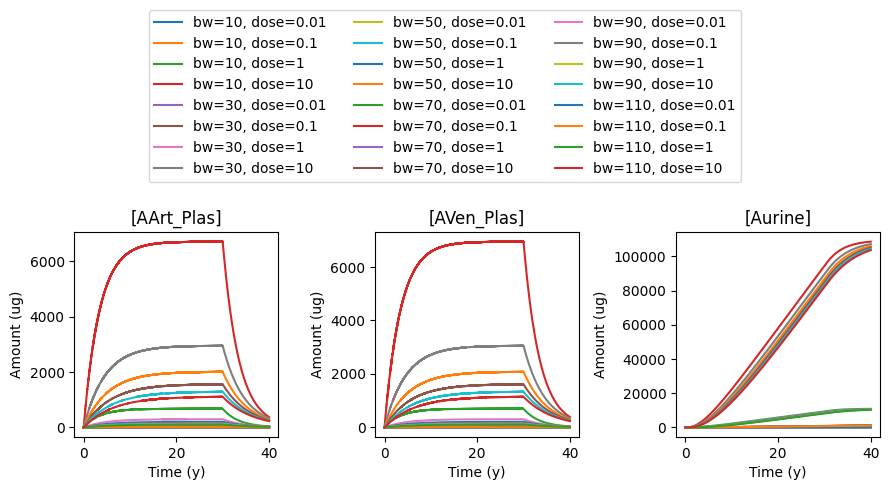

In [69]:
doses = [.01, .1, 1, 10]
bws = [10, 30, 50, 70, 90, 110]
selected_outputs = ["[AArt_Plas]", "[AVen_Plas]", "[Aurine]"]

ncols = min(len(selected_outputs), 4)
nrows = max(math.ceil((len(selected_outputs) - 1)/ncols), 1)
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.flatten()

for ax in axes:
    ax.set(xlabel='time') 
labels = selected_outputs

for i in range(0, len(selected_outputs)):
    sid = selected_outputs[i]
    axes[i].set(xlabel="Time (y)", ylabel=f"Amount (ug)", title=labels[i])

for bw in bws:
    for dose in doses:
        (res, outputs) = simulate(
            daily_per_bw_intake = dose,
            days_of_exposure = 30 * 365,
            days_after_exposure = 10 * 365,
            bw = bw
        )

        # Plot the results
        for i in range(0, len(selected_outputs)):
            sid = selected_outputs[i]
            axes[i].plot(res['time'] / 365, res[sid], label=f'bw={bw}, dose={dose}')
        for j in range(len(selected_outputs), nrows*ncols):
            fig.delaxes(axes[j])

handles, labels = fig.axes[0].get_legend_handles_labels()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1 + (.08 * len(bws) * len(doses) / 3)),
    ncols=max(ncols, 3)
)

fig.tight_layout()
